In [91]:
import numpy as np
import matplotlib.pyplot as plt

from pyvo.dal import tap
ESO_TAP_OBS = "http://archive.eso.org/tap_obs"
tapobs = tap.TAPService(ESO_TAP_OBS)

from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.wcs import WCS
from astropy.visualization import simple_norm
from astropy.nddata import Cutout2D

In [ ]:
query = """
SELECT TOP 10
    (s1.ra-s2.ra)*3600.0*COS(RADIANS(s1.dec)) as deltaRA,
    (s1.dec-s2.dec)*3600.0 as deltaDec,
    (s1.yAperMag3-s2.yAperMag3) as dy,
    (s1.jAperMag3-s2.jAperMag3) as dj,
    (s1.hAperMag3-s2.hAperMag3) as dh,
    (s1.ksAperMag3-s2.ksAperMag3) as dk
FROM vhsSource AS s1, vhsSource AS s2, vhsSourceNeighbours AS x
WHERE s1.yAperMag3 > 0 AND s2.yAperMag3 > 0 AND s1.jAperMag3 > 0 AND s2.jAperMag3 > 0
    AND s1.hAperMag3 > 0 AND s2.hAperMag3 > 0 AND s1.ksAperMag3 > 0 AND s2.ksAperMag3 > 0
    AND masterObjID=s1.sourceID AND slaveObjID=s2.sourceID 
    AND s1.priOrSec=s1.frameSetID AND distanceMins<0.05 AND distanceMins IN (
SELECT MIN(distanceMins)
FROM vhsSourceNeighbours
WHERE masterObjID=x.masterObjID) 
"""

In [55]:
hdu_img = fits.open('data/eso/ADP.2019-10-22T15_32_12.541.fits.fz')
hdu_img.info()

Filename: data/eso/ADP.2019-10-22T15_32_12.541.fits.fz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   ()      
  1  COMPRESSED_IMAGE    1 CompImageHDU    414   (12773, 15664)   int32   


In [56]:
hdu_cat = fits.open('data/eso/ADP.2019-11-05T14_19_52.272.fits')
hdu_cat.info()


Filename: data/eso/ADP.2019-11-05T14_19_52.272.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     371   ()      
  1  APM-BINARYTABLE    1 BinTableHDU    663   50678R x 80C   [1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E, 1E]   


In [108]:
ra, dec = 297.798380, -78.025972

In [94]:
w = WCS(hdu_img[1].header)
w

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : np.float64(297.621911683295) np.float64(-78.0328673529048) 
CRPIX : np.float64(6386.495) np.float64(7832.012) 
CD1_1 CD1_2  : np.float64(-9.48103822114492e-05) np.float64(-4.56479066671593e-07) 
CD2_1 CD2_2  : np.float64(4.89570058034691e-07) np.float64(-9.48217154314375e-05) 
NAXIS : 12773  15664

In [61]:
# w_cat = WCS(hdu_cat[1].header)
# w_cat
table = Table(hdu_cat[1].data)
# np.rad2deg(table['DEC'])

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


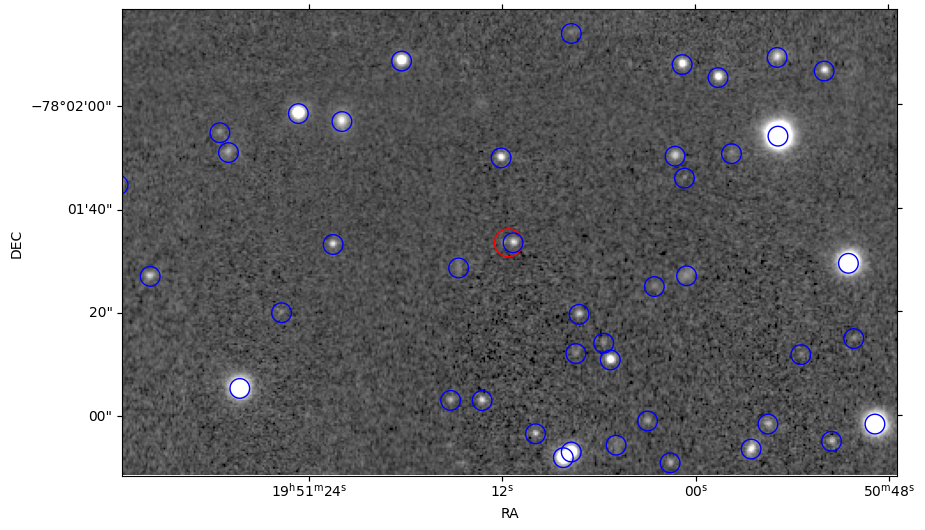

In [115]:
# Load the FITS file
# hdu_img = fits.open('data/eso/ADP.2019-10-22T15_32_12.541.fits.fz')

# Define the WCS object
w = WCS(hdu_img[1].header)

# Define the coordinates (ra, dec)
# ra = 297.621911683295
# dec = -78.0328673529048

# Convert the coordinates to pixel coordinates
position = SkyCoord(ra, dec, unit='deg')
position_pixel = position.to_pixel(w)

# Define the size of the cutout
size = u.Quantity((1.5, 2.5), u.arcmin)

# Create the cutout
cutout = Cutout2D(hdu_img[1].data, position_pixel, size=size, wcs=w)

# Extract the cutout data and WCS
data = cutout.data
cutout_wcs = cutout.wcs

# Plot the cutout
fig, ax = plt.subplots(1, 1, figsize=(10, 10), subplot_kw={'projection': cutout_wcs})
norm = simple_norm(data, 'sqrt', percent=99.0)
ax.imshow(data, cmap='gray', norm=norm)
# Add scatter points
scatter_coords = SkyCoord([ra], [dec], unit='deg')
scatter_pixel = scatter_coords.to_pixel(cutout_wcs)
ax.scatter(scatter_pixel[0], scatter_pixel[1], color='red', 
           marker='o', s=400, label='Target',
           facecolors='none')

# Convert the source coordinates to pixel coordinates
source_coords = SkyCoord(table['RA'], table['DEC'], unit='rad')
source_pixel = source_coords.to_pixel(cutout_wcs)
ax.scatter(source_pixel[0], source_pixel[1], color='blue', 
           marker='o', s=200, label='Sources',
           facecolors='none')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_xlim(0, data.shape[1])
ax.set_ylim(0, data.shape[0])
plt.show()